<a href="https://colab.research.google.com/github/SairajNeelam/EDA---Google-Play-Store/blob/main/NYC_Taxi_Time_Prediction_Supervised_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Importing necessary libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import calendar

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

## ***Data Overview***

In [3]:
# Read the dataset.
taxi = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Capstone Project/Datasets/NYC Taxi Time /Data _ Resources/NYC Taxi Data.csv')

In [4]:
taxi.head() #displays the first 5 rows of the dataset.

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Some observations about the data:
* The columns id and vendor_id are nominal.

* The columns pickup_datetime and dropoff_datetime are stored as object which must be converted to datetime for better analysis.
* The column store_and_fwd_flag is categorical

In [5]:
taxi.shape #Check shape of dataset

(1458644, 11)

In [6]:
taxi.info() # Displays the information of features in the form of data type
# Also we get to know if there are any Null values present in the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Lets look at the numerical columns

In [7]:
taxi.describe() 
# Displays the statistical information of those features which has int,float as datatype.

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


The returned table gives certain insights:
* There are no numerical columns with missing data
* The passenger count varies between 1 and 9 with most people number of people being 1 or 2
* The trip duration varying from 1s to 1939736s~538 hrs. There are definitely some outliers present which must be treated.

In [8]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Taxi dataset, which is equal to the number of records"%(taxi.id.nunique()))

There are 1458644 unique id's in Taxi dataset, which is equal to the number of records


There are 1458644 unique id's in Taxi dataset, which is equal to the number of records
So, Here we can say that there is no duplicate entry of any single trip.

In [9]:
#Check for NaN values
taxi.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no null values for any feature in the dataset

## ***Data Preprocessing***

### **Feature ▶ Pickup Datetime and Dropoff Datetime**

In [10]:
#Convert timestamp to datetime format to fetch the other details as listed below
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])

The 2 columns pickup_datetime and dropoff_datetime are now converted to datetime format which makes analysis of date and time data much more easier.

In [11]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


### **Feature ▶ Pickup lat,long and Dropoff lat,long**

In [12]:
taxi.describe() 

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [13]:
print(min(taxi['dropoff_latitude']))
print(max(taxi['dropoff_latitude']))
print(min(taxi['dropoff_longitude']))
print(max(taxi['dropoff_longitude']))

32.1811408996582
43.92102813720703
-121.9333038330078
-61.33552932739258


**New York/Coordinates**

**40.7128° N, 74.0060° W**

Now looking into the longitude the coordinates lies between (-74.53,-72.71) and the latitude coordinates lies between (40.44,41.09). But the pickup_latitude and pickup_longitude and dropoff_latitude and dropoff_laongitude lies outside this range. So let's clean them.

In [14]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

taxi = taxi[(taxi.pickup_latitude> south) & (taxi.pickup_latitude < north)]
taxi = taxi[(taxi.dropoff_latitude> south) & (taxi.dropoff_latitude < north)]
taxi = taxi[(taxi.pickup_longitude> west) & (taxi.pickup_longitude < east)]
taxi = taxi[(taxi.dropoff_longitude> west) & (taxi.dropoff_longitude < east)]

In [15]:
taxi.shape

(1438626, 11)

## ***Feature Engineering***

### **Feature ▶ Dropoff Datetime**

In [16]:
taxi['dropoff_hour'] = taxi.dropoff_datetime.dt.hour
taxi['dropoff_date'] = taxi['dropoff_datetime'].dt.date

### **Feature ▶ Pickup Datetime**

In [17]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
taxi['pickup_month'] = taxi.pickup_datetime.dt.month
taxi['pickup_year'] = taxi.pickup_datetime.dt.year
taxi['pickup_weekday_num'] = taxi.pickup_datetime.dt.weekday
taxi['pickup_hour'] = taxi.pickup_datetime.dt.hour
taxi['pickup_day'] = taxi['pickup_datetime'].dt.day

## ***Geospatial Analysis***

In [ ]:
df = taxi[['pickup_datetime', 'pickup_latitude', 'pickup_longitude']].copy()
df['day_of_week'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek
df['hour_of_day'] = pd.to_datetime(df['pickup_datetime']).dt.hour

In [ ]:
df.head()

,pickup_datetime,pickup_latitude,pickup_longitude,day_of_week,hour_of_day
0,2016-03-14 17:24:55,40.767937,-73.982155,0,17
1,2016-06-12 00:43:35,40.738564,-73.980415,6,0
2,2016-01-19 11:35:24,40.763939,-73.979027,1,11
3,2016-04-06 19:32:31,40.719971,-74.010040,2,19
4,2016-03-26 13:30:55,40.793209,-73.973053,5,13


#### **Now we are ready to start plotting maps**

In [ ]:
import folium 
from folium.plugins import HeatMap, HeatMapWithTime
import IPython
from IPython.display import IFrame

In [ ]:
#creating a function to display the map

def display_map(map, filename):
  map.save(filename)
  return IFrame(filename, width='100%', height='500px')

To plot heatmaps by time period, I use a nested for loop to iterate through every day of week and hour of day permutation. For each iteration in the for loop, I start by filtering data to include only observations for the day of week and hour of day, and save this asdf_geo. Then, I instantiate a map object, plot the heatmap on top, add a title to the heatmap and save the map locally. You should be able to go into the folder and open the saved heatmaps in your browser to view them!

In [ ]:
dow_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

In [ ]:
map_5 = folium.Map(location = [40.75,-73.96], tiles = 'openstreetmap', zoom_start=12)

In [ ]:
for day in range(df.day_of_week.min(), df.day_of_week.max()+1):
  for hour in range(df.hour_of_day.min(), df.hour_of_day.max()+1):

    # creating a filter to include data for each day_of_week and hour_of_day
    df_geo = df.loc[(df.day_of_week == day) & (df.hour_of_day == hour)][['pickup_latitude', 'pickup_longitude']].copy()
    # print(df_geo)


    # instantiating map object
    map_5 = folium.Map(location = [40.75,-73.96], tiles = 'openstreetmap', zoom_start=12)

    # ploting the HeatMap
    HeatMap(data=df_geo, radius=10).add_to(map_5)

    # get day_of_week from dow_dict
    d = dow_dict(day)
    print(d)

    # adding title to heatmap
    title_html = f'''<h3 align="center" style="font-size:20px">
                     <b>NYC Cab Pickups at {hour}:00 on {d}: {len(df_geo)} rides</b></h3>'''
                     
    map_5.get_root().html.add_child(folium.Element(title_html))

    # save the map
    display_map(map_5, f'./html_maps_pickup/{day}_{hour}_heatmap.html')

In [ ]:
from selenium import webdriver 
# from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
for i in range(0, 7):
    for j in range(0, 24):
        # Set file path
        tmpurl=f'file:///.../html_maps_pickup/{i}_{j}_heatmap.html'
        
        # Set browser to Chrome
        browser = webdriver.Chrome(executable_path = 'C:\chromedriver\chromedriver.exe')
        
        # Open file in browser
        browser.get(tmpurl)
        
        # If hour is < 10, add 0 for sorting purposes and to keep chronological order
        if j < 10:
            browser.save_screenshot(f'./maps_png_pickup/{i}_0{j}_heatmap.png')
        else:
            browser.save_screenshot(f'./maps_png_pickup/{i}_{j}_heatmap.png')
        
        # Close browser
        browser.quit()

In [ ]:
def png_to_gif(path_to_images, save_file_path, duration=500):
    frames = []
    
    # Retrieve image files
    images = glob.glob(f'{path_to_images}')
    
    # Loop through image files to open, resize them and append them to frames
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((550,389),Image.ANTIALIAS)
        frames.append(im.copy())
        
    # Save frames/ stitched images as .gif
    frames[0].save(f'{save_file_path}', format='GIF', append_images=frames[1:], save_all=True,
                   duration=duration, loop=0)

In [ ]:
import glob
from PIL import Image

In [ ]:
png_to_gif(path_to_images='./maps_png_pickup/*.png', 
           save_file_path='./heatmap_plots_gif/pickup_heatmap.gif',
           duration=500)

Credits ▶ https://python.plainenglish.io/creating-a-time-lapsed-heatmap-of-nyc-cab-pickup-locations-in-python-fef773b31427

**This output was generated on Jupyter Notebook because while running the code from line 22 Google Colab was crashing**

**The GIF file is uploaded on GitHub:**

**Link:** https://github.com/SairajNeelam/NYC-Taxi-Trip-Time-Prediction/blob/main/maps/nyc_cab_rides_heatmap.gif

Inference ▶



### **Map 2 - Pickup and Dropoff Locations**

In [ ]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dropoff_hour', 'dropoff_date', 'pickup_month',
       'pickup_weekday_num', 'pickup_hour', 'pickup_date'],
      dtype='object')

In [ ]:
df2 = taxi[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration']].copy()

In [ ]:
folium.TileLayer('Stamen Terrain').add_to(map_5)
folium.TileLayer('cartodbdark_matter').add_to(map_5)
folium.LayerControl().add_to(map_5)

In [ ]:
#folium only plots by looping through the rows of df. Only showing first 2000 points
for index, row in df2[:200000].iterrows(): 
    # print(row)
    folium.CircleMarker(location=[row['pickup_latitude'], row['pickup_longitude']], radius=1,color='#3186cc',
                        fill_color='#3186cc', opacity=0.4,
                    fillOpacity= 0.4, popup=('trip duration: '+str(row['trip_duration']))).add_to(map_5)
    folium.CircleMarker(location=[row['dropoff_latitude'], row['dropoff_longitude']], radius=1,color='indianred',
                        fill_color='indianred', opacity=0.4,
                    fillOpacity= 0.4, popup=('trip duration: '+str(row['trip_duration']))).add_to(map_5)

In [ ]:
display_map(map_5, 'circlemarker_map.html')

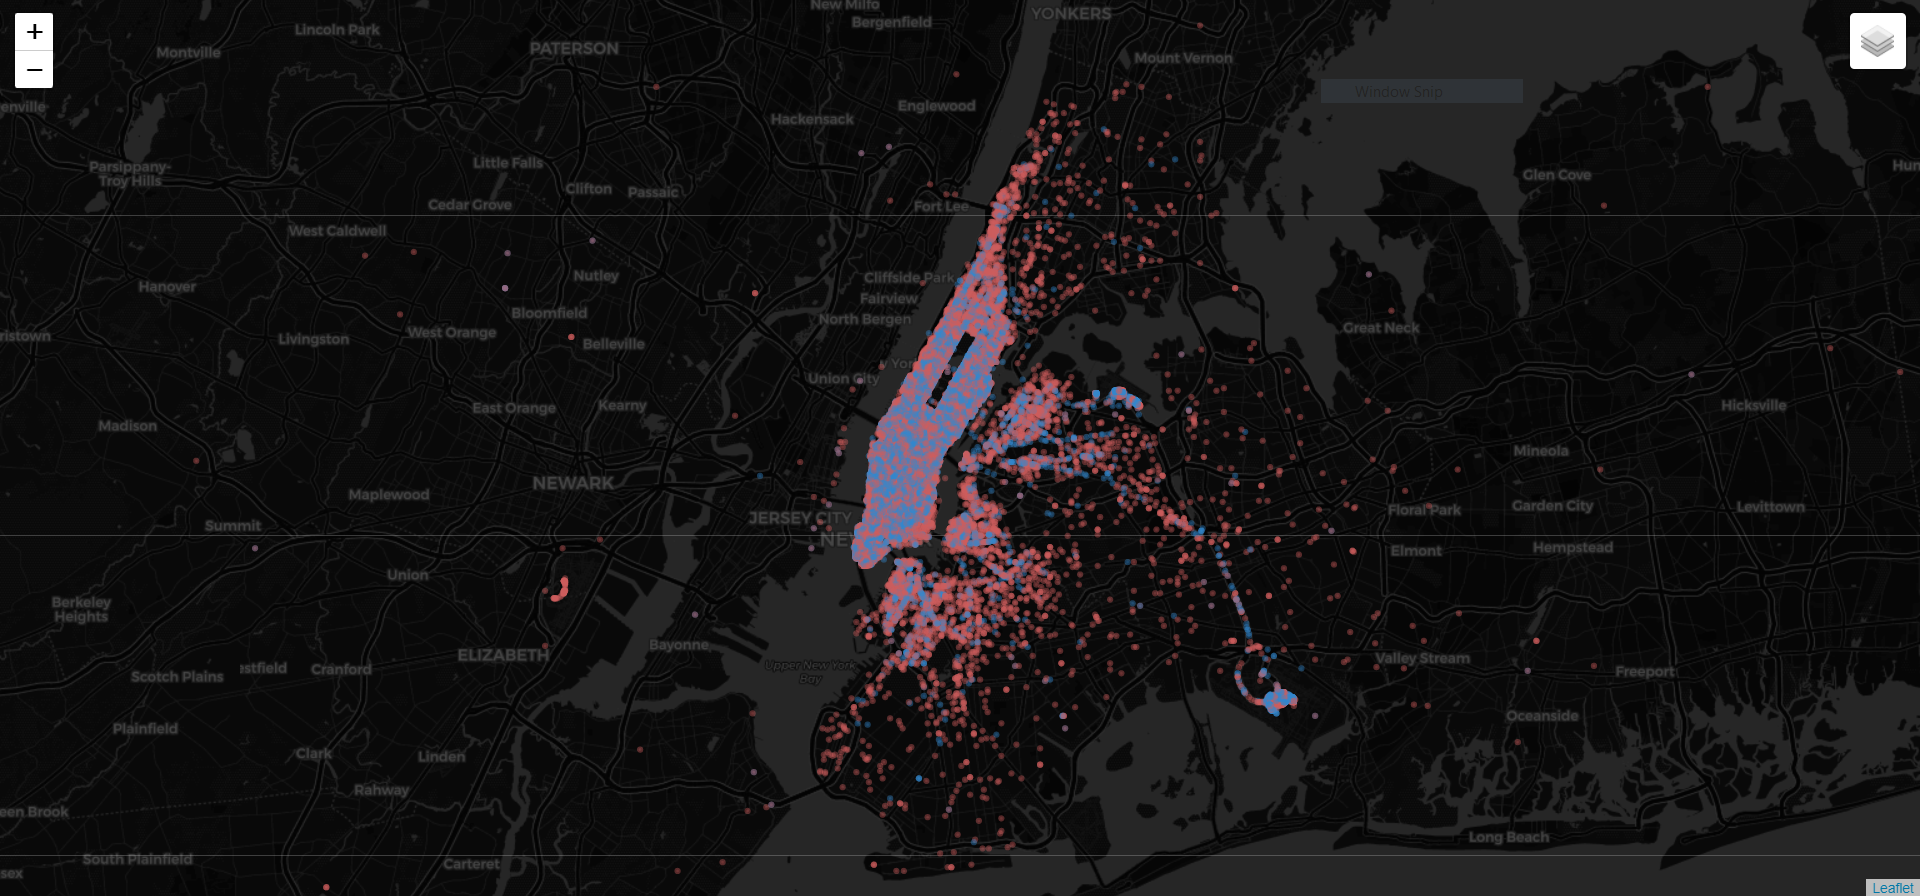

HeatMap for Pickups and Dropoffs

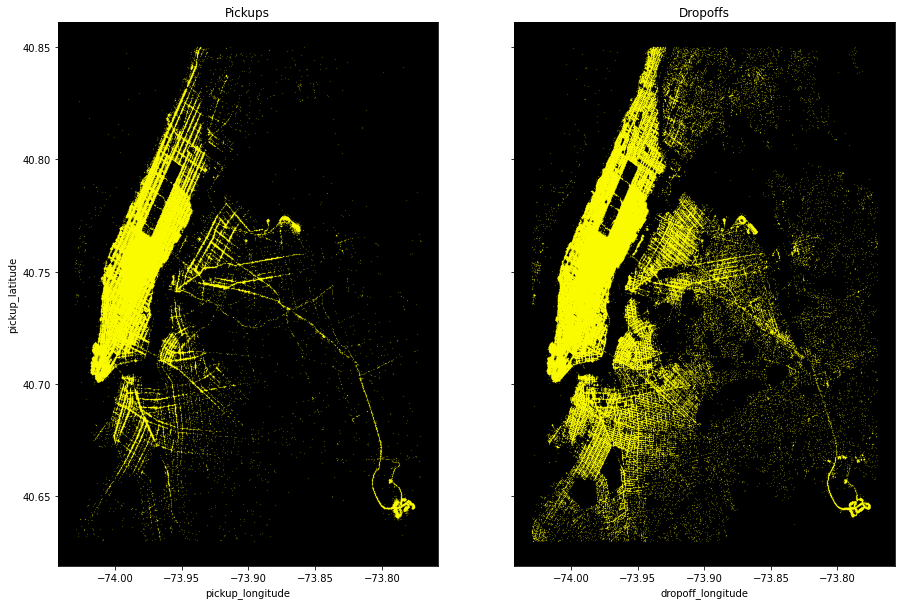

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

df2.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

df2.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

Inference ▶

From above two plots we can infer that,
* We see that most of the pickups and dropoffs happen in the core city(Manhattan)
* Also, we see that the dropoffs are more in Brooklyn and Queens considering the pickups from Brooklyn and Queens

## ***Exploratory Data Analysis***

In [18]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dropoff_hour', 'dropoff_date', 'pickup_month',
       'pickup_year', 'pickup_weekday_num', 'pickup_hour', 'pickup_day'],
      dtype='object')

### **Feature ▶ id (can tell us Number of Rides)**

#### **Yearwise**

In [19]:
taxi['pickup_year'].unique()

array([2016])

**OOPS!**

**The data is only for year 2016 so we cannot see the trend of HOW people have adapted to sharing cabs**

#### **Monthly**

In [20]:
trips_per_month = taxi[['pickup_month','id']].groupby(['pickup_month'],as_index = False).count().sort_values(by='pickup_month',ascending=True)

In [24]:
d = dict(enumerate(calendar.month_abbr))
# print(d)
trips_per_month['pickup_month'] = trips_per_month['pickup_month'].map(d)
trips_per_month.set_axis(['pickup_month','Total_number_of_rides'],axis=1,inplace=True)
trips_per_month.head()

,pickup_month,Total_number_of_rides
0,Jan,226669
1,Feb,235286
2,Mar,252720
3,Apr,248106
4,May,244832


In [25]:
trips_per_month.shape

(6, 2)

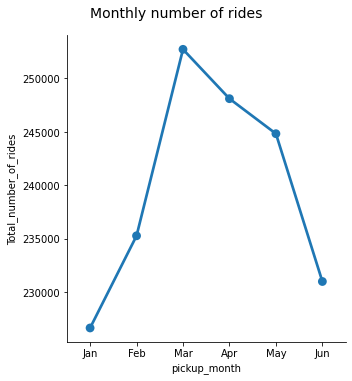

In [26]:
a = sns.factorplot(data=trips_per_month, x="pickup_month", y="Total_number_of_rides", ci=50)
a.fig.suptitle('Monthly number of rides', fontsize=14, y=1.05, fontdict={"weight": "bold"});

Inference ▶

We see the data is for only first 6 months.

There is increasing trend in the number of rides in the first 3 months and decrease in rides in next 3 months.

#### **Weekly**

In [27]:
trips_per_week = taxi[['pickup_weekday_num','id']].groupby(['pickup_weekday_num'],as_index = False).count().sort_values(by='pickup_weekday_num',ascending=True)

In [28]:
d = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

In [29]:
trips_per_week['pickup_weekday_num'] = trips_per_week['pickup_weekday_num'].map(d)
trips_per_week.set_axis(['pickup_week','Total_number_of_rides'],axis=1,inplace=True)
trips_per_week.head()

,pickup_week,Total_number_of_rides
0,Sun,184903
1,Mon,200136
2,Tue,207436
3,Wed,215577
4,Thu,220513


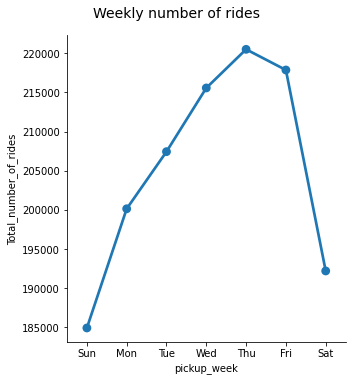

In [30]:
b = sns.factorplot(data=trips_per_week, x="pickup_week", y="Total_number_of_rides", ci=50)
b.fig.suptitle('Weekly number of rides', fontsize=14, y=1.05, fontdict={"weight": "bold"});

**Inference ▶**

**There is increase in number of rides from Monday to Friday and then the number of rides decreases on Saturday and Sunday.**

**So, what we can say that, as Mon-Fri are working days so people mostly use cabs to go to their work**

#### **Hourly**

In [31]:
trips_per_hour = taxi[['pickup_hour','id']].groupby(['pickup_hour'],as_index = False).count().sort_values(by='pickup_hour',ascending=True)

In [32]:
trips_per_hour.set_axis(['pickup_hour','Total_number_of_rides'],axis=1,inplace=True)
trips_per_hour.head()

,pickup_hour,Total_number_of_rides
0,0,51949
1,1,37567
2,2,27235
3,3,20249
4,4,15125


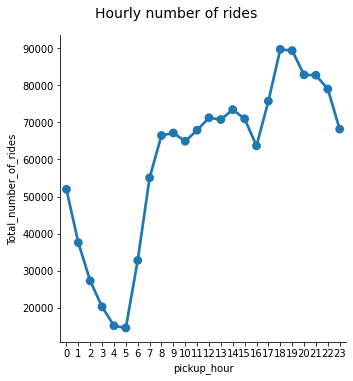

In [33]:
c = sns.factorplot(data=trips_per_hour, x="pickup_hour", y="Total_number_of_rides", ci=50)
c.fig.suptitle('Hourly number of rides', fontsize=14, y=1.05, fontdict={"weight": "bold"});

**Inference ▶**

**What we can infer from this plot is that the working hours start from morning 8:00 as there is sudden spike from 8:00AM and then work end at 18:00(6:00PM)**

**In between these hours there are mainly high number of rides happening**

#### **Heatmap for Hour vs Weekday**

In [34]:
hw = taxi[['pickup_weekday_num', 'pickup_hour', 'id']].groupby(['pickup_weekday_num','pickup_hour'],as_index = False).count().sort_values(by='pickup_weekday_num',ascending=True)
d = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
hw['pickup_weekday_num'] = hw['pickup_weekday_num'].map(d)

In [35]:
hw.set_axis(['pickup_week','pickup_hour','Total_number_of_rides'],axis=1,inplace=True)
hw.head()

,pickup_week,pickup_hour,Total_number_of_rides
0,Sun,0,4167
23,Sun,23,6777
22,Sun,22,9392
21,Sun,21,10980
20,Sun,20,11151


In [36]:
df_heatmap = hw.pivot_table(values='Total_number_of_rides',index='pickup_week',columns='pickup_hour')
df_heatmap.head()

pickup_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
pickup_week,,,,,,,,,,,,,,,,,,,,,,,,
Fri,11494,9746,8042,5892,3671,1914,2456,3647,5405,7801,9318,10193,11125,11261,10783,10757,9905,11167,12819,12938,11108,11258,12219,12952
Mon,4373,2494,1457,971,1093,2090,5707,9977,11522,10887,9416,9674,9673,9738,10297,9980,8853,10981,13367,12892,12534,12451,11273,8436
Sat,12050,10633,8405,6657,4327,1872,2084,2780,4265,6266,8607,10016,10532,10512,10444,10048,9692,10547,10958,9915,9009,8602,7754,6215
Sun,4167,2510,1610,1177,1295,2085,5289,8534,10259,9928,8553,8701,9046,9028,9808,9838,9077,10756,12843,12099,11151,10980,9392,6777
Thu,8548,5626,3820,2839,2207,2382,5463,9513,11369,10480,9476,9586,10200,10021,10819,10109,8746,10929,13266,14058,12649,12402,13084,12921


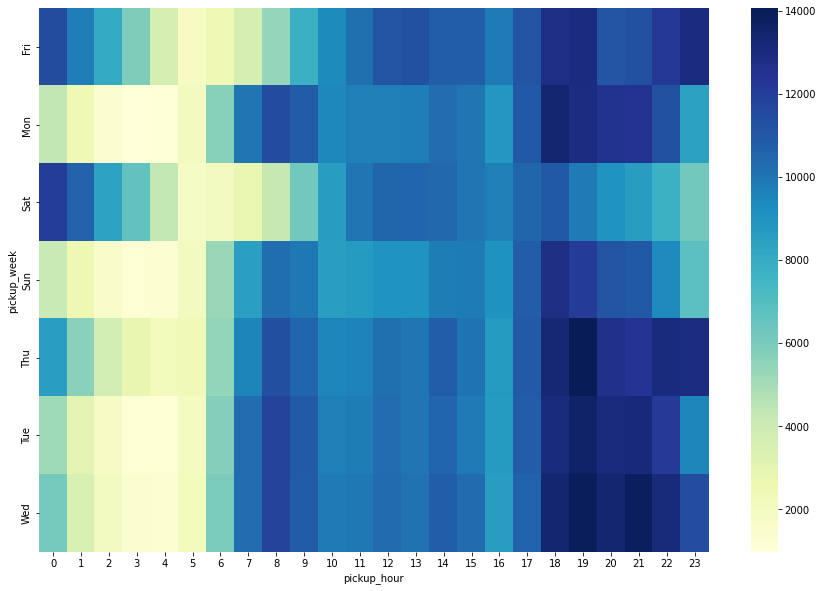

In [37]:
plt.figure(figsize=(15,10))
sns.heatmap(df_heatmap,annot=False,cmap="YlGnBu")
plt.show()

**Inference ▶**

* **On Friday and Saturday after midnight there are high number of taxi rides, this can be because of active nightlife in the city**

* **Also, Wednesday, Thursday and Friday there are high number of rides later in the evening after 6PM till midnight**

* **And there are high number of rides in the working time on weekdays (around 8-10AM and 6-10PM)**

#### **Heatmap for Hour vs Day for each Month**

In [38]:
mwd = taxi[['pickup_month','pickup_day', 'pickup_hour', 'id']].groupby(['pickup_month','pickup_day','pickup_hour'],as_index = False).count().sort_values(by='pickup_month',ascending=True)

In [39]:
d = dict(enumerate(calendar.month_abbr))
mwd['pickup_month'] = mwd['pickup_month'].map(d)

mwd.set_axis(['pickup_month','pickup_day', 'pickup_hour','Total_number_of_rides'],axis=1,inplace=True)
mwd.head()

,pickup_month,pickup_day,pickup_hour,Total_number_of_rides
0,Jan,1,0,536
485,Jan,21,5,102
486,Jan,21,6,205
487,Jan,21,7,428
488,Jan,21,8,497


In [40]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'] # we have data for only 6 months

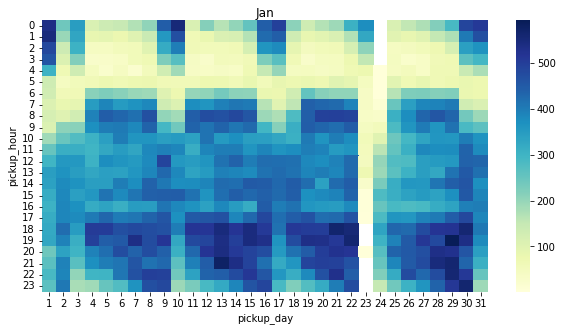

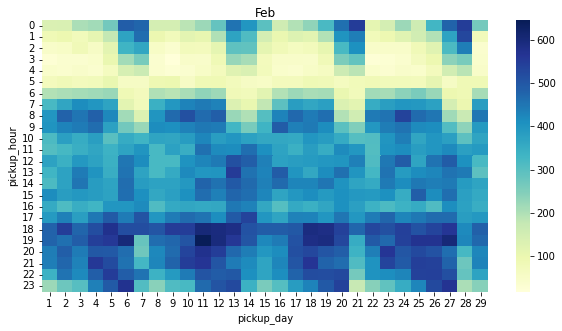

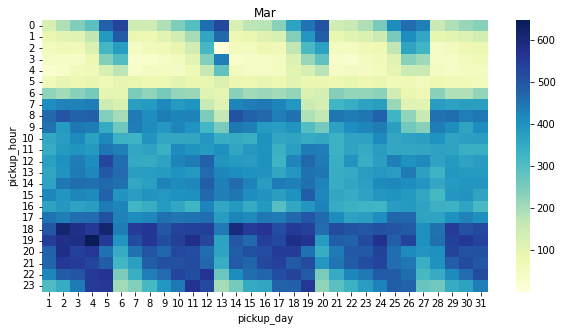

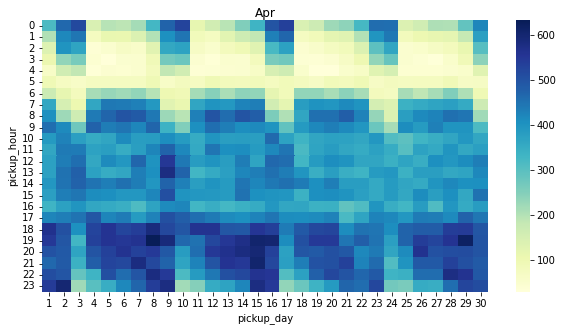

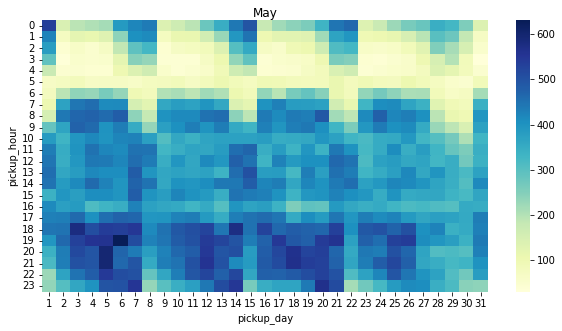

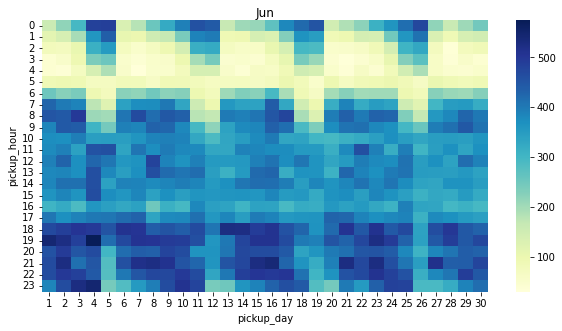

In [41]:
for month in month_list:
  temp_df = mwd.loc[mwd.pickup_month == month]
  temp_df_heatmap = temp_df.pivot_table(values='Total_number_of_rides',index='pickup_hour',columns='pickup_day')

  plt.figure(figsize=(10,5))
  sns.heatmap(temp_df_heatmap,annot=False,cmap="YlGnBu")
  plt.title(label=f'{month}', 
          fontweight=10, 
          pad='2.0')
  plt.show()

**Inference ▶**

> **JAN**
* **We see there are almost no rides on 23rd and 24th Jan. WHY?**
* **A travel ban was instituted for New York City and Newark, New Jersey for January 23–24.Because on January 2016 United States blizzard was a crippling and historic blizzard that produced up to 3 ft (91 cm) of snow in parts of the Mid-Atlantic and Northeastern United States from January 22–24, 2016.**




> **Rest other Months** 
* **The pattern is quite similar in all the months**
* **What we see is that,**
* **00-7AM   ➡ there are very few rides happening between**
* **8AM-6PM  ➡ there is increase in rides due to working hours** 
* **6PM-12AM ➡ high demand for rides, highest in a day**
* **This might happen because people people get ready for their jobs and work till 6-7PM, in this time frame we see the rides and after that they leave from office and from 7-00 people must be leaving for the city's night life due to which there is highest demand in this time frame**




